In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# External dependencies
import os

import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU
# import rmm

import nvtabular as nvt

from sklearn.model_selection import train_test_split

In [3]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("~/nvt-examples/end-to-end-poc/data/")
)

## Movie Feature Engineering

In [5]:
movie_genres = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_genres.parquet"))
movie_genres.head()

,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


In [6]:
movie_tags = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_tags.parquet"))
movie_tags.head()

,movieId,tags_unique,tags_nunique
0,1,"[2009 reissue in Stereoscopic 3-D, 3D, 55 movi...",126
1,2,"[Adaptation of Book, CLV, Children, Chris Van ...",44
2,3,"[Ann Margaret, Burgess Meredith, CLV, Daryl Ha...",23
3,4,"[CLV, based on novel or book, characters, chic...",8
4,5,"[CLV, Comedy, Diane Keaton, Fantasy, Steve Mar...",20


In [7]:
tags_ds = nvt.Dataset(movie_tags)

In [8]:
CATEGORICAL_COLUMNS = ["tags_unique", "movieId"]
CONTINUOUS_COLUMNS = []
LABEL_COLUMNS = []

In [9]:
cat_with_genres = CATEGORICAL_COLUMNS >> nvt.ops.JoinExternal(movie_genres, on=["movieId"])

In [10]:
cat_features = cat_with_genres >> nvt.ops.Categorify()

In [11]:
cont_features = nvt.ColumnGroup(CONTINUOUS_COLUMNS)

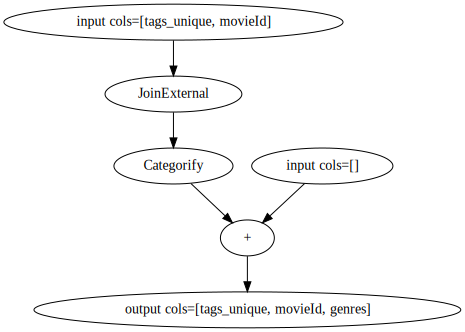

In [12]:
output = cat_features + cont_features
(output).graph

In [13]:
workflow = nvt.Workflow(output)

In [14]:
%%time
workflow.fit(tags_ds)

CPU times: user 410 ms, sys: 23.5 ms, total: 434 ms
Wall time: 434 ms


In [15]:
%time
movie_features = workflow.transform(tags_ds)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


In [16]:
movie_features.to_parquet(os.path.join(INPUT_DATA_DIR, "movie_features.parquet"))

## Ratings Feature Engineering

In [17]:
# TODO: Use NVTabular to make these changes

In [18]:
ratings = cudf.read_csv(os.path.join(INPUT_DATA_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [19]:
ratings_ds = nvt.Dataset(ratings)

In [45]:
min_day = ratings["timestamp"].min() // 86400

def create_day_column(ts, df):
    day = ts // 86400
    day = day - min_day
    return day

day_feature = ["timestamp"] >> nvt.ops.LambdaOp(create_day_column) >> nvt.ops.Rename(f=lambda x: "day")

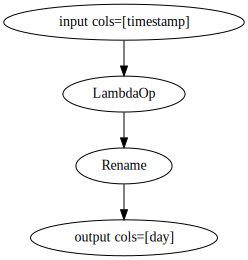

In [46]:
output.graph

In [47]:
workflow = nvt.Workflow(output)

In [48]:
%%time
workflow.fit(ratings_ds)

CPU times: user 30.4 ms, sys: 0 ns, total: 30.4 ms
Wall time: 29.2 ms


In [49]:
%time
ratings_features = workflow.transform(ratings_ds)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [50]:
ratings_features.to_ddf().head()

,day
0,4146
1,4146
2,4146
3,4146
4,4146


In [ ]:
ratings_features.to_parquet(os.path.join(INPUT_DATA_DIR, "ratings_features.parquet"))

In [22]:
ratings["day"] = ratings["timestamp"] // 86400
min_day = ratings.min()["day"]
ratings["day"] = ratings["day"] - min_day
ratings = ratings.sort_values("timestamp")
ratings.head()

,userId,movieId,rating,timestamp,day
326761,2262,21,3.0,789652009,0.0
326767,2262,47,5.0,789652009,0.0
326810,2262,1079,3.0,789652009,0.0
2016249,13424,10,3.0,822873600,385.0
2016250,13424,11,4.0,822873600,385.0


In [23]:
ratings["day"].min()

0.0

In [24]:
ratings["interaction"] = ratings["rating"] > 3.0
ratings.head()

,userId,movieId,rating,timestamp,day,interaction
326761,2262,21,3.0,789652009,0.0,False
326767,2262,47,5.0,789652009,0.0,True
326810,2262,1079,3.0,789652009,0.0,False
2016249,13424,10,3.0,822873600,385.0,False
2016250,13424,11,4.0,822873600,385.0,True


## Train/Validation Split

In [25]:
# TODO: Change this to a temporal split

In [26]:
train, valid = train_test_split(
    ratings[ratings["interaction"]],
    test_size=0.2,
    random_state=42,
)

In [27]:
train.head()

,userId,movieId,rating,timestamp,day,interaction
10731606,69691,88744,3.5,1454386068,7694.0,True
1419558,9539,2028,5.0,1077074601,3327.0,True
23436845,152128,115122,3.5,1482504237,8019.0,True
11711831,75919,4993,4.0,1189482809,4628.0,True
20611457,134058,224,5.0,904414393,1328.0,True


In [28]:
train.to_parquet(os.path.join(INPUT_DATA_DIR, "train.parquet"))
valid.to_parquet(os.path.join(INPUT_DATA_DIR, "valid.parquet"))

## Join Ratings With Features

In [29]:
movie_features_ddf = movie_features.to_ddf()
movie_features_ddf.head()

,tags_unique,movieId,genres
0,"[477, 581, 640, 1857, 2175, 2817, 3538, 4395, ...",1,"[3, 4, 5, 6, 10]"
1,"[1206, 4448, 5069, 5213, 7883, 8912, 9116, 925...",2,"[3, 5, 10]"
2,"[2196, 4356, 4448, 6484, 11460, 12274, 17647, ...",3,"[6, 16]"
3,"[4448, 31525, 34749, 34981, 39134, 48169, 6086...",4,"[6, 9, 16]"
4,"[4448, 5693, 6977, 8912, 23756, 25354, 28604, ...",5,[6]


In [30]:
train_ratings_ddf = movie_features_ddf.merge(train, on="movieId")
train_ratings_ddf.head()

,tags_unique,movieId,genres,userId,rating,timestamp,day,interaction
0,"[477, 581, 640, 1857, 2175, 2817, 3538, 4395, ...",1,"[3, 4, 5, 6, 10]",229,5.0,834440626,518.0,True
1,[65664],33815,[6],93,4.5,1496530730,8181.0,True
2,"[48205, 53440, 67112]",43930,[8],93,3.5,1496530773,8181.0,True
3,"[5604, 6464, 25735, 25864, 29593, 30253, 31336...",44022,"[6, 9, 20]",93,4.0,1496530815,8181.0,True
4,"[10795, 11968, 13514, 14210, 14873, 17949, 282...",44665,"[2, 7, 18]",62,4.0,1229434808,5090.0,True


In [31]:
# TODO: Sample a tag for each interaction

In [32]:
# TODO: Group by user id and day to form "sessions"

In [33]:
# TODO: Aggregate genres and tags

In [34]:
# TODO: Figure out how to maintain temporal order when grouping